In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000241_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000042_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000073_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000215_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000325_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000320_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000238_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000278_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000186_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000025_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000069_resized.png
/kaggle/input/themassiveindianfooddataset/Paneer-Tikka-resized/00000120_resi

In [2]:
# The data in comparison to the Original Data has been reduced to 10%
# This clearly means that there is substantially less training data and the
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} Directories and {len(filenames)} Files in '{dirpath}'")

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting up Global Variables for better Re-usability
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_dir="../input/themassiveindianfooddataset/"
train_data_generator=ImageDataGenerator(rescale=1/255.)
# test_data_generator=ImageDataGenerator(rescale=1/255.)
train_data=train_data_generator.flow_from_directory(train_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical")

Found 886 images belonging to 3 classes.


In [4]:
# Function as we need to modularize it to be reusable for all the
# Also we will be saving them to the log_dir for all the Different models we built
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [5]:
train_data

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
# Function to Create a Model from an Input url
# 3 Classes as this starter Notebook is made on the Initial Dataset
def create_model(model_url, num_classes=3):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           # freeze the underlying patterns
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           # define the input image shape
                                           input_shape=IMAGE_SHAPE+(3,)) 
  
  # Create our own model using the feature extraction layer as the base
  model = tf.keras.Sequential([
    feature_extractor_layer, 
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [10]:
# Fitting the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=6,
                                  steps_per_epoch=len(train_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  # save experiment logs here
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                         # name of log files
                                                                         experiment_name="resnet50V2")]) 

2022-01-23 08:48:40.911804: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-23 08:48:40.911987: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-23 08:48:40.913236: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220123-084840


2022-01-23 08:48:41.452013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
 1/28 [>.............................] - ETA: 3:03 - loss: 1.4920 - accuracy: 0.2188

2022-01-23 08:48:48.682030: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-23 08:48:48.682227: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/28 [=>............................] - ETA: 1:05 - loss: 1.3740 - accuracy: 0.2656

2022-01-23 08:48:50.792704: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-23 08:48:50.804644: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-23 08:48:50.818971: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50V2/20220123-084840/train/plugins/profile/2022_01_23_08_48_50

2022-01-23 08:48:50.822498: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tensorflow_hub/resnet50V2/20220123-084840/train/plugins/profile/2022_01_23_08_48_50/b5610f48dd81.trace.json.gz
2022-01-23 08:48:50.849029: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tensorflow_hub/resnet50V2/20220123-084840/train/plugins/profile/2022_01_23_08_48_50

2022-01-23 08:48:50.851526: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to t

 4/28 [===>..........................] - ETA: 52s - loss: 1.2572 - accuracy: 0.3203

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


28/28 [==============================] - 63s 2s/step - loss: 0.7463 - accuracy: 0.6625
Epoch 2/6
28/28 [==============================] - 57s 2s/step - loss: 0.3374 - accuracy: 0.8883
Epoch 3/6
28/28 [==============================] - 56s 2s/step - loss: 0.2489 - accuracy: 0.9210
Epoch 4/6
28/28 [==============================] - 56s 2s/step - loss: 0.2018 - accuracy: 0.9424
Epoch 5/6
28/28 [==============================] - 56s 2s/step - loss: 0.1664 - accuracy: 0.9605
Epoch 6/6
28/28 [==============================] - 57s 2s/step - loss: 0.1454 - accuracy: 0.9729


In [11]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']


  accuracy = history.history['accuracy']


  epochs = range(len(history.history['loss']))
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

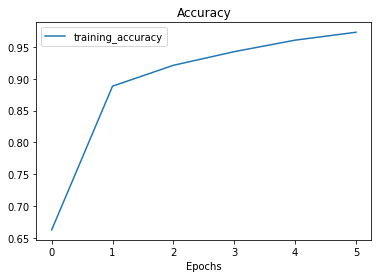

In [12]:
plot_loss_curves(resnet_history)